In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from arion.models.core import  ArionModel

In [2]:
df_race = pd.read_csv("../data/results/processed/results_processed.csv", parse_dates=['date','datetime'])

In [3]:
train = df_race.loc[(df_race.date < '2021-01-01')].copy()
test = df_race.loc[(df_race.date >= '2021-01-01') & (df_race.date < '2022-01-01')].copy()
not_features = ['race_id','date','datetime','won','price','horse_name','finish_pos']

In [4]:
model = ArionModel(not_features=not_features)
model.train(train=train)

[LightGBM] [Info] Total Bins 40463
[LightGBM] [Info] Number of data points in the train set: 696973, number of used features: 172
[LightGBM] [Info] Total Bins 40464
[LightGBM] [Info] Number of data points in the train set: 522729, number of used features: 172
[LightGBM] [Info] Total Bins 40454
[LightGBM] [Info] Number of data points in the train set: 522730, number of used features: 172
[LightGBM] [Info] Total Bins 40466
[LightGBM] [Info] Number of data points in the train set: 522730, number of used features: 172
[LightGBM] [Info] Total Bins 40398
[LightGBM] [Info] Number of data points in the train set: 522730, number of used features: 172
[LightGBM] [Info] Number of positive: 74767, number of negative: 622206
[LightGBM] [Info] Total Bins 40973
[LightGBM] [Info] Number of data points in the train set: 696973, number of used features: 174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
def bet_simulate(t, kelly_min, prob_min ,starting_balance):
    trial = df_race.loc[t.index,["race_id","last_price","won","date","price","horse_name"]].copy()

    trial["pred_prob"] = model.predict(X=t)
    trial["pred_sp"] = 1/trial["pred_prob"]
    trial["kelly"] = ((trial["pred_prob"]*trial["last_price"]) - 1)/(trial["last_price"] - 1)
    
    trial["bet"] = (trial["pred_prob"] > prob_min)  & (trial['kelly'] > kelly_min)
    isnoise = [len(str(i)) > 5 for i in trial["last_price"]]
    #trial.loc[isnoise,"last_price"] = trial.loc[isnoise,"dec"]
    trial["winnings"] = (trial['bet'] * trial["kelly"] * starting_balance * trial["last_price"] * trial["won"] * 0.95) - (trial['bet'] * trial["kelly"] * starting_balance)
    trial["bank"] = trial["winnings"].cumsum()
    trial["bet size"] = trial["bet"]*trial["kelly"]*starting_balance

    return trial

def evaluate(t,prob_min = 0.2,kelly_min = 0.05):


    t = bet_simulate(t,prob_min=prob_min,kelly_min=kelly_min ,starting_balance = 1000)

    roi = sum(t["winnings"])/sum(t["bet"] * t["kelly"] * 1000)
    sr = sum((t['bet']) & (t['won']))/sum(t["bet"])

    final_balance = round(int(t['bank'][-1:]),2)
    bets_per_day = round(sum(t['bet'])/len(t['date'].unique()),2)
    print(sum(t['bet']))
    ROI = round(roi*100,2)
    SR = round(sr*100,2)
    min_balance = round(min(t["bank"]),2) + 100 
    avg_betsize_day = t.groupby('date')['bet size'].sum()
    avg_bet_size = round(t.loc[t['bet'] ==1,"bet size"].mean(),2)
    max_bet = round(t.loc[t['bet'] ==1,"bet size"].max(),2)

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    plot = plt.plot(t['date'],t['bank'], label = f"Min predicted prob:{prob_min}, Min kelly threshold: {kelly_min}")
    plt.ylabel("Profit £")
    plt.legend()
    out = {'prob_min':prob_min,
           'kelly_min':kelly_min,
           'final_balance':final_balance,
           'bets_per_day':bets_per_day,
           'ROI':ROI,
           'SR':SR,
           'min_balance':min_balance,
           'avg_bet_size':avg_bet_size,
           'max_bet':max_bet}

    return out,plot


9307
7286
5602
4723
4195
3690
2230
2082
1950


,prob_min,kelly_min,final_balance,bets_per_day,ROI,SR,min_balance,avg_bet_size,max_bet
0,0.1,0.02,69027,27.70,11.64,21.18,-105.53,63.71,452.92
1,0.1,0.03,72325,21.68,13.33,22.82,-37.12,74.48,452.92
2,0.1,0.04,72351,16.67,14.95,24.90,-37.12,86.39,452.92
3,0.2,0.02,53562,14.06,13.19,29.94,-75.26,85.97,452.92
4,0.2,0.03,54715,12.49,13.93,30.51,37.91,93.64,452.92
5,0.2,0.04,56493,10.98,15.05,31.41,-101.92,101.70,452.92
6,0.3,0.02,33340,6.64,13.11,38.92,-504.19,114.03,452.92
7,0.3,0.03,33635,6.20,13.42,39.19,-455.20,120.34,452.92
8,0.3,0.04,33819,5.80,13.75,39.38,-452.71,126.14,452.92


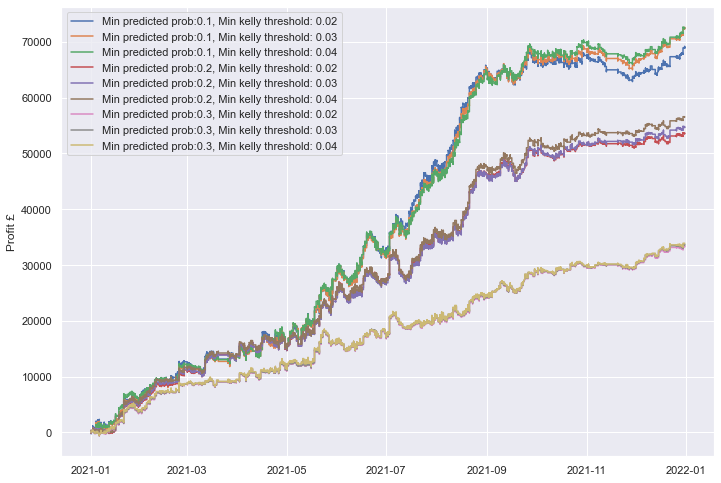

In [14]:
outs = []
params = []
for i in [0.1,0.2,0.3]:
    for j in [0.02,0.03,0.04]:
        params.append([i,j])
        outs.append(evaluate(test,prob_min=i, kelly_min = j))

plt.savefig("simulation.png")

pd.DataFrame([d[0] for d in outs])